In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import random
from tensorflow.keras import layers, models, optimizers, callbacks
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import pickle

2025-06-12 13:44:24.198450: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-12 13:44:24.280465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749703464.309858  209522 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749703464.318813  209522 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-12 13:44:24.371134: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [9]:
# ==== CONFIG ====
IMG_SIZE = 128
DATA_DIR = "/mnt/d/MyEverything/PythonProjects/Recent_projects/cnn_analysis/Hand_Drawing/quickdraw_images"
PARTIAL_STEPS = [0.8, 0.9, 1.0]  # Less aggressive masking
BATCH_SIZE = 64  # Increased for better gradient estimates
#EPOCHS = 10
CLASSES_LIMIT = 338
target_val_acc = 0.89
EPOCHS_PER_CHUNK = 1

In [2]:
def get_filepaths_and_labels(base_dir):
    classes = sorted(os.listdir(base_dir))
    if CLASSES_LIMIT:
        classes = classes[:CLASSES_LIMIT]
    all_paths = []
    all_labels = []
    class_to_idx = {cls: i for i, cls in enumerate(classes)}
    for cls in classes:
        class_path = os.path.join(base_dir, cls)
        images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith('.png')]
        all_paths.extend(images)
        all_labels.extend([cls] * len(images))
    return all_paths, all_labels, class_to_idx

#all_paths, all_labels, _=get_filepaths_and_labels(DATA_DIR)

In [3]:
def partition_class_images_progressively(base_dir, chunk_size=200, max_chunks=5):
    """Progressive partitioning with better data distribution"""
    classes = sorted(os.listdir(base_dir))
    if CLASSES_LIMIT:
        classes = classes[:CLASSES_LIMIT]
 
    partitions_per_epoch = [[] for _ in range(max_chunks)]
    label_partitions_per_epoch = [[] for _ in range(max_chunks)]
    class_to_idx = {cls: i for i, cls in enumerate(classes)}

    # Store all images per class for better distribution
    class_images = {}
    for cls in classes:
        class_path = os.path.join(base_dir, cls)
        images = [
            os.path.join(class_path, img)
            for img in os.listdir(class_path)
            if img.lower().endswith('.png')
        ]
        random.shuffle(images)
        class_images[cls] = images

    for epoch_idx in range(max_chunks):
        for cls in classes:
            images = class_images[cls]
            total = len(images)
            num_images = min(chunk_size * (epoch_idx + 1), total)  # Don't exceed available images
            
            if total >= num_images:
                selected_images = images[:num_images]
            else:
                # Use all available images without repetition to avoid overfitting
                selected_images = images
                
            partitions_per_epoch[epoch_idx].extend(selected_images)
            label_partitions_per_epoch[epoch_idx].extend([cls] * len(selected_images))

    return partitions_per_epoch, label_partitions_per_epoch, class_to_idx

In [26]:
# class SketchDataGenerator(tf.keras.utils.Sequence):
#     def __init__(self, filepaths, labels, batch_size, class_to_idx, steps=[1.0], shuffle=True, vali=False,stratify_ratio=0.8):
#         self.filepaths = np.array(filepaths)
#         self.labels = np.array(labels)
#         self.batch_size = batch_size
#         self.class_to_idx = class_to_idx
#         self.steps = steps
#         self.shuffle = shuffle
#         self.vali = vali
#         self.stratify_ratio = stratify_ratio
#         self.indices = np.arange(len(self.filepaths))
#         self.on_epoch_end()

#     def __len__(self):
#         return len(self.filepaths) // self.batch_size

#     def __getitem__(self, index):
#         inds = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
#         batch_x = self.filepaths[inds]
#         batch_y = [self.class_to_idx[self.labels[i]] for i in inds]
#         X = []
        
#         for path in batch_x:
#             img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            
#             if img is None:
#                 img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
#             else:
#                 img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

#             # CRITICAL FIX: Apply same preprocessing to both train and validation
#             # Only apply masking to a small fraction of training samples
#             if not self.vali and random.random() < 0.3:  # Only 30% of training samples get masked
#                 step_ratio = random.choice(self.steps)
#                 if step_ratio < 1.0:
#                     direction = random.choice(["top", "bottom", "left", "right"])
#                     dim = int(IMG_SIZE * (1.0 - step_ratio))
#                     if direction == "top":
#                         img[:dim, :] = 255
#                     elif direction == "bottom":
#                         img[-dim:, :] = 255
#                     elif direction == "left":
#                         img[:, :dim] = 255
#                     elif direction == "right":
#                         img[:, -dim:] = 255

#             # Consistent normalization
#             img = img.astype(np.float32) / 255.0
#             img = np.expand_dims(img, axis=-1)
#             X.append(img)

#         X = np.array(X)
#         y = tf.keras.utils.to_categorical(batch_y, num_classes=len(self.class_to_idx))
#         return X, y

#     def on_epoch_end(self):
#         if self.shuffle:
#             np.random.shuffle(self.indices)

In [4]:
class SketchDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, filepaths, labels, batch_size, class_to_idx, steps=[1.0], shuffle=True, vali=False, stratify_ratio=0.8):
        self.filepaths = np.array(filepaths)
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.class_to_idx = class_to_idx
        self.steps = steps
        self.shuffle = shuffle
        self.vali = vali
        self.stratify_ratio = stratify_ratio  # Fraction of batch to be stratified
        
        # Group indices by class for stratified sampling
        self.class_indices = {}
        for idx, label in enumerate(labels):
            class_idx = self.class_to_idx[label]
            if class_idx not in self.class_indices:
                self.class_indices[class_idx] = []
            self.class_indices[class_idx].append(idx)
        
        self.num_classes = len(self.class_indices)
        self.indices = np.arange(len(self.filepaths))
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.filepaths) // self.batch_size
    
    def __getitem__(self, index):
        # Stratified sampling: ensure diverse class representation
        stratified_samples = int(self.batch_size * self.stratify_ratio)
        random_samples = self.batch_size - stratified_samples
        
        # Get stratified samples (at least one from each available class)
        stratified_indices = []
        classes_to_sample = list(self.class_indices.keys())
        np.random.shuffle(classes_to_sample)
        
        # Sample at least one from each class (up to stratified_samples)
        samples_per_class = max(1, stratified_samples // min(len(classes_to_sample), stratified_samples))
        
        for i, class_idx in enumerate(classes_to_sample):
            if len(stratified_indices) >= stratified_samples:
                break
            
            # Sample from this class
            class_pool = self.class_indices[class_idx]
            n_samples = min(samples_per_class, 
                          stratified_samples - len(stratified_indices),
                          len(class_pool))
            
            selected = np.random.choice(class_pool, size=n_samples, replace=False)
            stratified_indices.extend(selected)
        
        # Fill remaining with random samples
        remaining_indices = list(set(self.indices) - set(stratified_indices))
        if random_samples > 0 and len(remaining_indices) > 0:
            random_selected = np.random.choice(remaining_indices, 
                                             size=min(random_samples, len(remaining_indices)), 
                                             replace=False)
            stratified_indices.extend(random_selected)
        
        # Ensure we have exactly batch_size samples
        if len(stratified_indices) < self.batch_size:
            additional_needed = self.batch_size - len(stratified_indices)
            additional_samples = np.random.choice(self.indices, size=additional_needed, replace=True)
            stratified_indices.extend(additional_samples)
        
        # Truncate if we somehow got too many
        inds = stratified_indices[:self.batch_size]
        
        batch_x = self.filepaths[inds]
        batch_y = [self.class_to_idx[self.labels[i]] for i in inds]
        
        X = []
        for path in batch_x:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            
            if img is None:
                img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
            else:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            
            # Apply masking only to training data
            if not self.vali and random.random() < 0.3:
                step_ratio = random.choice(self.steps)
                if step_ratio < 1.0:
                    direction = random.choice(["top", "bottom", "left", "right"])
                    dim = int(IMG_SIZE * (1.0 - step_ratio))
                    if direction == "top":
                        img[:dim, :] = 255
                    elif direction == "bottom":
                        img[-dim:, :] = 255
                    elif direction == "left":
                        img[:, :dim] = 255
                    elif direction == "right":
                        img[:, -dim:] = 255
            
            # Consistent normalization
            img = img.astype(np.float32) / 255.0
            img = np.expand_dims(img, axis=-1)
            X.append(img)
        
        X = np.array(X)
        y = tf.keras.utils.to_categorical(batch_y, num_classes=len(self.class_to_idx))
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            # Shuffle indices within each class
            for class_idx in self.class_indices:
                np.random.shuffle(self.class_indices[class_idx])
    
    def get_class_distribution_debug(self, num_batches=5):
        """Debug function to check class distribution across batches"""
        all_classes = set()
        for i in range(min(num_batches, len(self))):
            _, y = self.__getitem__(i)
            batch_classes = set(np.argmax(y, axis=1))
            all_classes.update(batch_classes)
            print(f"Batch {i}: {len(batch_classes)} unique classes")
        
        print(f"Total unique classes across {num_batches} batches: {len(all_classes)}")
        print(f"Coverage: {len(all_classes)}/{self.num_classes} ({100*len(all_classes)/self.num_classes:.1f}%)")
        return all_classes

In [27]:
# def build_cnn_model(input_shape, num_classes):
#     """Simplified model to prevent overfitting"""
#     model = models.Sequential([
#         layers.Input(shape=input_shape),

#         # First block - more aggressive pooling
#         layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D(4),  # Aggressive pooling
#         layers.Dropout(0.25),

#         # Second block
#         layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D(2),
#         layers.Dropout(0.25),

#         # Third block
#         layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
#         layers.BatchNormalization(),
#         layers.GlobalAveragePooling2D(),
#         layers.Dropout(0.5),

#         # Classifier with heavy regularization
#         layers.Dense(512, activation='relu'),
#         layers.BatchNormalization(),
#         layers.Dropout(0.6),
#         layers.Dense(num_classes, activation='softmax')
#     ])
    
#     # Much lower learning rate and weight decay
#     optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, weight_decay=1e-4)
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

In [49]:
def build_resnet_scratch(input_shape, num_classes, depth = None , filters = None):
    if depth is None:
        depth = [2, 2, 2, 2]
    if filters is None:
        filters = [32, 64, 128, 256]
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(filters[0], 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    for stage, (blocks, f) in enumerate(zip(depth, filters)):
        for b in range(blocks):
            strides = 2 if b == 0 and stage > 0 else 1
            y = layers.Conv2D(f, 3, strides=strides, padding='same', use_bias=False)(x)
            y = layers.BatchNormalization()(y)
            y = layers.ReLU()(y)
            y = layers.Conv2D(f, 3, padding='same', use_bias=False)(y)
            y = layers.BatchNormalization()(y)

            if strides != 1 or x.shape[-1] != f:
                x = layers.Conv2D(f, 1, strides=strides, use_bias=False)(x)
                x = layers.BatchNormalization()(x)
            x = layers.add([x, y])
            x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, weight_decay=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [5]:
# Create a global train/val split to ensure consistency
def create_global_split(all_paths, all_labels, test_size=0.2, random_state=42):
    """Create a consistent global train/validation split"""
    return train_test_split(all_paths, all_labels, test_size=test_size, 
                          stratify=all_labels, random_state=random_state)

class ValidationMonitor(callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.val_accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy', 0)
        self.val_accs.append(val_acc)
        
        # Stop if validation accuracy hasn't improved in 3 epochs
        if len(self.val_accs) > 3:
            recent_accs = self.val_accs[-3:]
            if all(acc <= self.val_accs[-4] for acc in recent_accs):
                print(f"\n[WARNING] Validation accuracy stuck at {val_acc:.4f}. Consider stopping.")
        
        # Emergency stop if validation accuracy is extremely low
        if val_acc < 0.05 and epoch > 0:
            print(f"\n[EMERGENCY STOP] Validation accuracy too low: {val_acc:.4f}")
            self.model.stop_training = True

In [7]:
class StepCheckpoint(callbacks.Callback):
    def __init__(self, save_dir, save_freq_steps=2000, max_checkpoints=2):
        super(StepCheckpoint, self).__init__()
        self.save_dir = save_dir
        self.save_freq_steps = save_freq_steps
        self.max_checkpoints = max_checkpoints
        self.batch_count = 92000 #change accordingly
        self.checkpoint_paths = []
        os.makedirs(save_dir, exist_ok=True)

    def on_train_batch_end(self, batch, logs=None):
        self.batch_count += 1
        if self.batch_count % self.save_freq_steps == 0:
            filename = os.path.join(self.save_dir, f"step_{self.batch_count}.keras")
            self.model.save(filename)
            self.checkpoint_paths.append(filename)
            print(f"[Checkpoint] Saved model at step {self.batch_count}")

            if len(self.checkpoint_paths) > self.max_checkpoints:
                old_checkpoint = self.checkpoint_paths.pop(0)
                if os.path.exists(old_checkpoint):
                    os.remove(old_checkpoint)

def preview_batch_images(images, labels, idx_to_class, num=8):
    plt.figure(figsize=(15, 4))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        class_idx = np.argmax(labels[i])
        plt.title(idx_to_class[class_idx])
        plt.axis('off')
    plt.show()
    
# def debug_data_distribution(train_gen, val_gen, class_to_idx):
#     """Debug function to check data distribution"""
#     print("\n=== DATA DISTRIBUTION DEBUG ===")
    
#     # Check a few batches from each generator
#     train_batch_x, train_batch_y = train_gen[0]
#     val_batch_x, val_batch_y = val_gen[0]
    
#     print(f"Train batch shape: {train_batch_x.shape}")
#     print(f"Train batch range: [{train_batch_x.min():.3f}, {train_batch_x.max():.3f}]")
#     print(f"Val batch shape: {val_batch_x.shape}")
#     print(f"Val batch range: [{val_batch_x.min():.3f}, {val_batch_x.max():.3f}]")
    
#     # Check if images look similar
#     train_mean = np.mean(train_batch_x)
#     val_mean = np.mean(val_batch_x)
#     print(f"Train batch mean: {train_mean:.3f}")
#     print(f"Val batch mean: {val_mean:.3f}")
    
#     # Check class distribution in batches
#     train_classes = np.argmax(train_batch_y, axis=1)
#     val_classes = np.argmax(val_batch_y, axis=1)
#     print(f"Train batch unique classes: {len(np.unique(train_classes))}")
#     print(f"Val batch unique classes: {len(np.unique(val_classes))}")
#     print("=== END DEBUG ===\n")

def debug_data_distribution(train_gen, val_gen, class_to_idx):
    """Debug function to check data distribution across multiple batches"""
    print("\n=== DATA DISTRIBUTION DEBUG ===")
    
    # Check multiple batches from each generator
    num_batches_to_check = 5
    
    # Train data checks
    train_classes = []
    for i in range(min(num_batches_to_check, len(train_gen))):
        train_batch_x, train_batch_y = train_gen[i]
        batch_classes = np.argmax(train_batch_y, axis=1)
        train_classes.extend(batch_classes)
        
    # Val data checks
    val_classes = []
    for i in range(min(num_batches_to_check, len(val_gen))):
        val_batch_x, val_batch_y = val_gen[i]
        batch_classes = np.argmax(val_batch_y, axis=1)
        val_classes.extend(batch_classes)
    
    print(f"Checked {num_batches_to_check} batches from each generator")
    print(f"Train data - Unique classes: {len(np.unique(train_classes))}")
    print(f"Val data - Unique classes: {len(np.unique(val_classes))}")
    
    # Check if all classes are represented
    all_classes = set(range(len(class_to_idx)))
    missing_in_train = all_classes - set(np.unique(train_classes))
    missing_in_val = all_classes - set(np.unique(val_classes))
    
    print(f"\nClasses missing in train samples: {len(missing_in_train)}")
    print(f"Classes missing in val samples: {len(missing_in_val)}")
    
    # Check image statistics
    print("\nImage statistics:")
    print(f"Train mean: {np.mean(train_batch_x):.4f} ± {np.std(train_batch_x):.4f}")
    print(f"Val mean: {np.mean(val_batch_x):.4f} ± {np.std(val_batch_x):.4f}")
    print("=== END DEBUG ===\n")

In [10]:
# Main execution
max_chunks = 10  # Reduced number of epochs
chunk_size = 369  # Smaller chunks to prevent overfitting
CACHE_PATH = "partitioned_cache_fixed.pkl"

# Load or create partitioned data
if os.path.exists(CACHE_PATH):
    print("[INFO] Loading partitioned data from cache...")
    with open(CACHE_PATH, 'rb') as f:
        partitioned_paths, partitioned_labels, full_class_to_idx = pickle.load(f)

    # ENFORCE CLASSES_LIMIT on class_to_idx
    allowed_classes = sorted(list(full_class_to_idx.keys()))[:CLASSES_LIMIT]
    class_to_idx = {cls: i for i, cls in enumerate(allowed_classes)}

    # Filter paths/labels accordingly
    filtered_partitioned_paths = []
    filtered_partitioned_labels = []

    for epoch_paths, epoch_labels in zip(partitioned_paths, partitioned_labels):
        filtered_paths = []
        filtered_labels = []
        for p, l in zip(epoch_paths, epoch_labels):
            if l in class_to_idx:
                filtered_paths.append(p)
                filtered_labels.append(l)
        filtered_partitioned_paths.append(filtered_paths)
        filtered_partitioned_labels.append(filtered_labels)

    partitioned_paths = filtered_partitioned_paths
    partitioned_labels = filtered_partitioned_labels

else:
    print("Creating partitioned data...")
    partitioned_paths, partitioned_labels, class_to_idx = partition_class_images_progressively(
        DATA_DIR, chunk_size=chunk_size, max_chunks=max_chunks
    )
    with open(CACHE_PATH, 'wb') as f:
        pickle.dump((partitioned_paths, partitioned_labels, class_to_idx), f)
    print("[INFO] Saved partitioned data to cache.")

[INFO] Loading partitioned data from cache...


In [10]:
# Create GLOBAL train/validation split using first epoch data
# print("[INFO] Creating global train/validation split...")
# from collections import defaultdict
# import random

# def create_fixed_validation_set(all_paths, all_labels, images_per_class=100, seed=42):
#     """
#     Create a fixed validation set of `images_per_class` images for each class.
#     Returns:
#         train_paths, val_paths, train_labels, val_labels
#     """
#     random.seed(seed)
#     class_to_images = defaultdict(list)
    
#     for path, label in zip(all_paths, all_labels):
#         class_to_images[label].append(path)
    
#     val_paths = []
#     val_labels = []
#     train_paths = []
#     train_labels = []

#     for label, paths in class_to_images.items():
#         if len(paths) < images_per_class:
#             raise ValueError(f"Not enough images for class '{label}' to allocate {images_per_class} validation samples")
        
#         random.shuffle(paths)
#         val_samples = paths[:images_per_class]
#         train_samples = paths[images_per_class:]

#         val_paths.extend(val_samples)
#         val_labels.extend([label] * images_per_class)
#         train_paths.extend(train_samples)
#         train_labels.extend([label] * len(train_samples))
    
#     return train_paths, val_paths, train_labels, val_labels

[INFO] Creating global train/validation split...


In [11]:
import os
import random
from collections import defaultdict

def create_fixed_validation_set_only(base_dir, images_per_class=50, seed=42):
    """
    Creates a fixed validation set by selecting `images_per_class` random images from each class.
    Only loads the minimum number of paths needed to build the validation set.
    """
    random.seed(seed)
    classes = sorted(os.listdir(base_dir))
    if CLASSES_LIMIT:
        classes = classes[:CLASSES_LIMIT]

    val_paths = []
    val_labels = []

    for cls in classes:
        class_path = os.path.join(base_dir, cls)
        images = [img for img in os.listdir(class_path) if img.endswith('.png')]
        
        if len(images) < images_per_class:
            raise ValueError(f"Not enough images for class '{cls}' to allocate {images_per_class} validation samples")

        selected = random.sample(images, images_per_class)
        val_paths.extend([os.path.join(class_path, img) for img in selected])
        val_labels.extend([cls] * images_per_class)

    print(f"[INFO] Validation set created with {len(val_paths)} images across {len(set(val_labels))} classes")
    return val_paths, val_labels


In [12]:
print("[INFO] Creating fixed global validation set...")

# global_train_paths, global_val_paths, global_train_labels, global_val_labels = create_fixed_validation_set(
#     all_paths, all_labels, images_per_class=100
# )
global_val_paths, global_val_labels = create_fixed_validation_set_only(DATA_DIR, images_per_class=50)
val_set = set(global_val_paths)  # For quick lookup

print(f"[INFO] Global validation set created:")
#print(f"  Training samples: {len(global_train_paths)}")
print(f"  Validation samples: {len(global_val_paths)}")
#print(f"  Classes in training: {len(set(global_train_labels))}")
print(f"  Classes in validation: {len(set(global_val_labels))}")

[INFO] Creating fixed global validation set...
[INFO] Validation set created with 16900 images across 338 classes
[INFO] Global validation set created:
  Validation samples: 16900
  Classes in validation: 338


In [56]:
# Build model
model = build_resnet_scratch((IMG_SIZE, IMG_SIZE, 1), len(class_to_idx))
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 64, 64,    │      1,568 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_46[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_34 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ re_lu_34[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 32, 32,    │      9,216 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_47[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_35 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 32, 32,    │      9,216 │ re_lu_35[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_48[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 32, 32,    │          0 │ max_pooling2d_6[… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_36 (ReLU)     │ (None, 32, 32,    │          0 │ add_16[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 32, 32,    │      9,216 │ re_lu_36[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_37 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 32, 32,    │      9,216 │ re_lu_37[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_50[0][0] 

 Total params: 2,887,410 (11.01 MB)

 Trainable params: 2,882,610 (11.00 MB)

 Non-trainable params: 4,800 (18.75 KB)

In [13]:
# Training callbacks
validation_monitor = ValidationMonitor()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=3, restore_best_weights=True, min_delta=0.01
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6, verbose=1
)
checkpoint_callback = StepCheckpoint(save_dir="./checkpoints", save_freq_steps=2000, max_checkpoints=2)

In [14]:
# Use the SAME validation set for all epochs
val_gen = SketchDataGenerator(global_val_paths, global_val_labels, BATCH_SIZE, 
                            class_to_idx, [1.0], shuffle=True, vali=True)

print(f"\n[INFO] Starting training with consistent validation set...")


[INFO] Starting training with consistent validation set...



EPOCH 5
Current epoch training samples: 623201
Batch 0: 62 unique classes
Batch 1: 63 unique classes
Batch 2: 62 unique classes
Batch 3: 63 unique classes
Batch 4: 61 unique classes
Total unique classes across 5 batches: 216
Coverage: 216/338 (63.9%)

=== DATA DISTRIBUTION DEBUG ===
Checked 5 batches from each generator
Train data - Unique classes: 210
Val data - Unique classes: 216

Classes missing in train samples: 128
Classes missing in val samples: 122

Image statistics:
Train mean: 0.9723 ± 0.1447
Val mean: 0.9707 ± 0.1485
=== END DEBUG ===



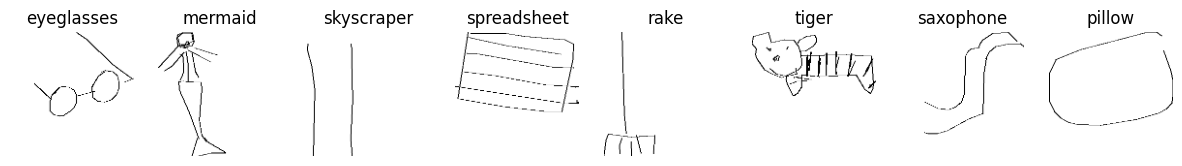

Training on 623201 samples, validating on 16900 samples
[Checkpoint] Saved model at step 42000━━━━━━━━━━━━━━ 2:32:20 1s/step - accuracy: 0.6267 - loss: 1.5478   
[Checkpoint] Saved model at step 44000━━━━━━━━━━━━━━ 1:53:13 989ms/step - accuracy: 0.6290 - loss: 1.5365 
[Checkpoint] Saved model at step 4600037m━━━━━━━━━━━ 1:23:01 1s/step - accuracy: 0.6308 - loss: 1.5287    
[Checkpoint] Saved model at step 48000━━━━━━ 48:19 1s/step - accuracy: 0.6322 - loss: 1.5223  
[Checkpoint] Saved model at step 50000━━━━━ 14:00 968ms/step - accuracy: 0.6335 - loss: 1.5164 
9737/9737 ━━━━━━━━━━━━━━━━━━━━ 9472s 973ms/step - accuracy: 0.6340 - loss: 1.5139 - val_accuracy: 0.5851 - val_loss: 1.6855 - learning_rate: 1.0000e-04

Epoch 5 Summary:
  Train Acc: 0.6397
  Val Acc: 0.5851
  Val Loss: 1.6855

EPOCH 6
Current epoch training samples: 747840
Batch 0: 62 unique classes
Batch 1: 61 unique classes
Batch 2: 60 unique classes
Batch 3: 64 unique classes
Batch 4: 61 unique classes
Total unique classes ac

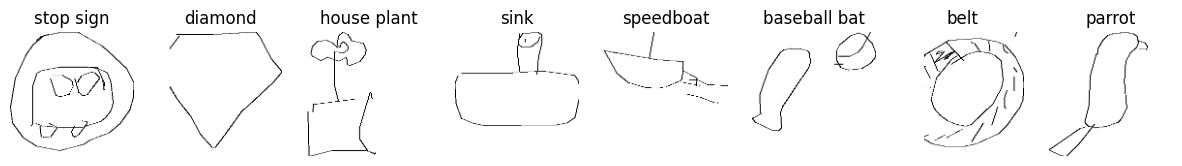

Training on 747840 samples, validating on 16900 samples
[Checkpoint] Saved model at step 52000━━━━━━━━━━━━━━━━ 2:37:17 894ms/step - accuracy: 0.6424 - loss: 1.4765
[Checkpoint] Saved model at step 54000m━━━━━━━━━━━━━━━ 2:07:06 892ms/step - accuracy: 0.6428 - loss: 1.4727
[Checkpoint] Saved model at step 56000━━━━━━━━━━━━ 1:40:56 924ms/step - accuracy: 0.6441 - loss: 1.4674
[Checkpoint] Saved model at step 58000━━━━━━━━ 1:10:01 923ms/step - accuracy: 0.6454 - loss: 1.4617
[Checkpoint] Saved model at step 60000━━━━━━━ 40:53 961ms/step - accuracy: 0.6466 - loss: 1.4570  
[Checkpoint] Saved model at step 62000━━━━━━━ 9:04 983ms/step - accuracy: 0.6475 - loss: 1.4529 
11685/11685 ━━━━━━━━━━━━━━━━━━━━ 0s 986ms/step - accuracy: 0.6478 - loss: 1.4518  
[WARNING] Validation accuracy stuck at 0.5749. Consider stopping.
11685/11685 ━━━━━━━━━━━━━━━━━━━━ 11713s 1s/step - accuracy: 0.6478 - loss: 1.4518 - val_accuracy: 0.5749 - val_loss: 1.7450 - learning_rate: 1.0000e-04

Epoch 6 Summary:
  Train A

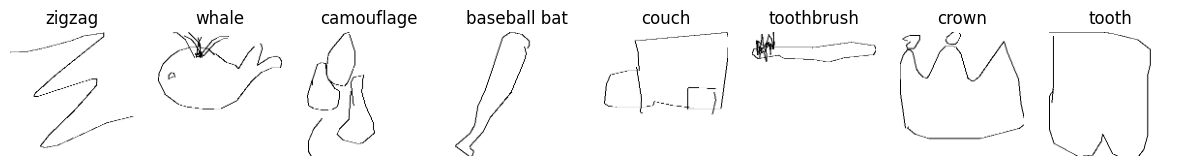

Training on 872469 samples, validating on 16900 samples
[Checkpoint] Saved model at step 64000━━━━━━━━━━━━━━━━ 3:27:52 1s/step - accuracy: 0.6597 - loss: 1.4112
[Checkpoint] Saved model at step 66000m━━━━━━━━━━━━━━━ 2:50:48 1s/step - accuracy: 0.6597 - loss: 1.4069
[Checkpoint] Saved model at step 6800037m━━━━━━━━━━━━━ 2:22:47 1s/step - accuracy: 0.6599 - loss: 1.4035
[Checkpoint] Saved model at step 70000m━━━━━━━━━━ 1:53:09 1s/step - accuracy: 0.6603 - loss: 1.3999
[Checkpoint] Saved model at step 72000━━━━━━━ 1:15:23 1s/step - accuracy: 0.6608 - loss: 1.3965
[Checkpoint] Saved model at step 74000━━━━━━━ 39:07 1s/step - accuracy: 0.6613 - loss: 1.3935  
[Checkpoint] Saved model at step 76000━━━━━━━ 3:21 1s/step - accuracy: 0.6619 - loss: 1.3906 
13632/13632 ━━━━━━━━━━━━━━━━━━━━ 14938s 1s/step - accuracy: 0.6619 - loss: 1.3903 - val_accuracy: 0.3201 - val_loss: 3.5138 - learning_rate: 1.0000e-04

Epoch 7 Summary:
  Train Acc: 0.6656
  Val Acc: 0.3201
  Val Loss: 3.5138
[WARNING] Large 

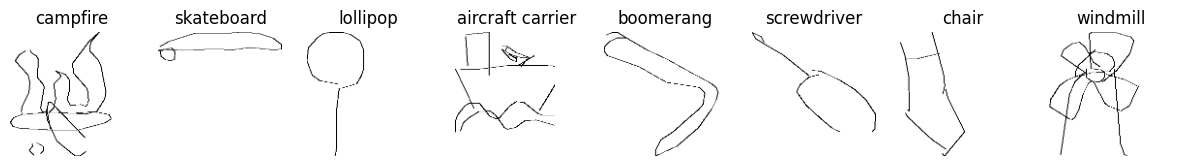

Training on 997092 samples, validating on 16900 samples
[Checkpoint] Saved model at step 78000━━━━━━━━━━━━━━━━ 4:05:27 1s/step - accuracy: 0.6713 - loss: 1.3562
[Checkpoint] Saved model at step 80000━━━━━━━━━━━━━━━━ 3:10:42 973ms/step - accuracy: 0.6716 - loss: 1.3524 
[Checkpoint] Saved model at step 8200037m━━━━━━━━━━━━━ 2:50:13 1s/step - accuracy: 0.6718 - loss: 1.3497    
[Checkpoint] Saved model at step 84000m━━━━━━━━━━ 2:18:45 1s/step - accuracy: 0.6720 - loss: 1.3479
[Checkpoint] Saved model at step 86000━━━━━━━━ 1:45:56 1s/step - accuracy: 0.6722 - loss: 1.3462
[Checkpoint] Saved model at step 88000━━━━━━━ 1:09:40 1s/step - accuracy: 0.6725 - loss: 1.3444
[Checkpoint] Saved model at step 90000━━━━━━━ 31:30 1s/step - accuracy: 0.6728 - loss: 1.3426  

[WARNING] Validation accuracy stuck at 0.3900. Consider stopping.
15579/15579 ━━━━━━━━━━━━━━━━━━━━ 17478s 1s/step - accuracy: 0.6731 - loss: 1.3409 - val_accuracy: 0.3900 - val_loss: 3.0997 - learning_rate: 1.0000e-04

Epoch 8 Summ

In [ ]:
# Training loop with consistent validation
#for epoch in range(max(3, len(partitioned_paths))):
epoch=8
while epoch<10:# Limit to 3 epochs for testing
    print(f"\n{'='*50}")
    print(f"EPOCH {epoch + 1}")
    print(f"{'='*50}")
    
    # For training, use progressive data but SAME validation set
    epoch_paths = partitioned_paths[epoch]
    epoch_labels = partitioned_labels[epoch]
    
    # Filter training data to match our global training split
    train_paths_current = []
    train_labels_current = []
    
    # for path, label in zip(epoch_paths, epoch_labels):
    #     if path in set(global_train_paths):  # Only use paths that were in training split
    #         train_paths_current.append(path)
    #         train_labels_current.append(label)
    for path, label in zip(epoch_paths, epoch_labels):
        if path not in val_set:  # Exclude validation images
            train_paths_current.append(path)
            train_labels_current.append(label)

    print(f"Current epoch training samples: {len(train_paths_current)}")
    
    if len(train_paths_current) == 0:
        print("No training samples for this epoch, skipping...")
        continue
    
    # Create training generator for current epoch
    train_gen = SketchDataGenerator(train_paths_current, train_labels_current, BATCH_SIZE, 
                                  class_to_idx, PARTIAL_STEPS, shuffle=True, vali=False)

    train_gen.get_class_distribution_debug(num_batches=5)
    
    # Debug data distribution
    debug_data_distribution(train_gen, val_gen, class_to_idx)
    # Optional: Preview training images
    train_batch_x, train_batch_y = train_gen[0]
    preview_batch_images(train_batch_x, train_batch_y, {v: k for k, v in class_to_idx.items()})
    # Train model
    print(f"Training on {len(train_paths_current)} samples, validating on {len(global_val_paths)} samples")
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS_PER_CHUNK,
        callbacks=[checkpoint_callback,validation_monitor, early_stopping, reduce_lr],
        verbose=1
    )
    
    # Print epoch summary
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Acc: {final_train_acc:.4f}")
    print(f"  Val Acc: {final_val_acc:.4f}")
    print(f"  Val Loss: {history.history['val_loss'][-1]:.4f}")
    
    # Stop if we're clearly overfitting
    if final_train_acc - final_val_acc > 0.3:
        print("[WARNING] Large train-val accuracy gap detected. Consider stopping.")
    
    if final_val_acc >= target_val_acc:
        print(f"Target validation accuracy {target_val_acc} reached!")
        break
    epoch+=1

print("\n[INFO] Training completed!")

In [15]:
from tensorflow.keras.models import load_model

# Load the saved model checkpoint from step_90000
model = load_model("./checkpoints/step_90000.keras")
print("[INFO] Loaded model from step_90000.keras")
model.summary()

I0000 00:00:1749705225.600712  209522 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


[INFO] Loaded model from step_90000.keras


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 64, 64,    │      1,568 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_46[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_34 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ re_lu_34[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 32, 32,    │      9,216 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_47[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_35 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 32, 32,    │      9,216 │ re_lu_35[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_48[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 32, 32,    │          0 │ max_pooling2d_6[… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_36 (ReLU)     │ (None, 32, 32,    │          0 │ add_16[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 32, 32,    │      9,216 │ re_lu_36[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_37 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 32, 32,    │      9,216 │ re_lu_37[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_50[0][0] 

 Total params: 8,652,632 (33.01 MB)

 Trainable params: 2,882,610 (11.00 MB)

 Non-trainable params: 4,800 (18.75 KB)

 Optimizer params: 5,765,222 (21.99 MB)


EPOCH 9
Current epoch training samples: 1121436
Batch 0: 62 unique classes
Batch 1: 62 unique classes
Batch 2: 61 unique classes
Batch 3: 62 unique classes
Batch 4: 60 unique classes
Total unique classes across 5 batches: 224
Coverage: 224/338 (66.3%)

=== DATA DISTRIBUTION DEBUG ===
Checked 5 batches from each generator
Train data - Unique classes: 210
Val data - Unique classes: 210

Classes missing in train samples: 128
Classes missing in val samples: 128

Image statistics:
Train mean: 0.9692 ± 0.1528
Val mean: 0.9723 ± 0.1440
=== END DEBUG ===



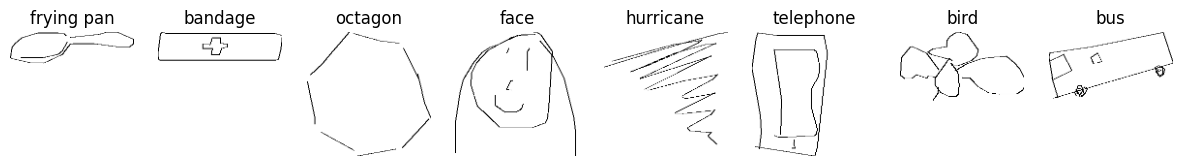

/mnt/c/Windows/system32/tf_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1749705280.193692  323790 service.cc:148] XLA service 0x7f057c003350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749705280.194695  323790 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-06-12 14:14:40.520760: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749705281.691247  323790 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-12 14:14:43.651049

[Checkpoint] Saved model at step 94000━━━━━━━━━━━━━━━━ 6:06:32 1s/step - accuracy: 0.6785 - loss: 1.3212
[Checkpoint] Saved model at step 96000━━━━━━━━━━━━━━━━ 4:58:23 1s/step - accuracy: 0.6787 - loss: 1.3209
[Checkpoint] Saved model at step 980007m━━━━━━━━━━━━━━ 4:22:46 1s/step - accuracy: 0.6792 - loss: 1.3189
[Checkpoint] Saved model at step 100000━━━━━━━━━━━ 3:26:11 1s/step - accuracy: 0.6797 - loss: 1.3167
[Checkpoint] Saved model at step 102000m━━━━━━━━━ 2:38:01 1s/step - accuracy: 0.6801 - loss: 1.3145
[Checkpoint] Saved model at step 104000━━━━━━━ 1:53:19 1s/step - accuracy: 0.6805 - loss: 1.3125
[Checkpoint] Saved model at step 106000
[Checkpoint] Saved model at step 108000━━━━━━ 30:11 1s/step - accuracy: 0.6812 - loss: 1.3086  
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6815 - loss: 1.3071   

2025-06-12 19:58:57.262382: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_457', 16 bytes spill stores, 16 bytes spill loads



17522/17522 ━━━━━━━━━━━━━━━━━━━━ 20853s 1s/step - accuracy: 0.6815 - loss: 1.3071 - val_accuracy: 0.6922 - val_loss: 1.2369 - learning_rate: 1.0000e-04

Epoch 9 Summary:
  Train Acc: 0.6851
  Val Acc: 0.6922
  Val Loss: 1.2369

EPOCH 10
Current epoch training samples: 1245705
Batch 0: 64 unique classes
Batch 1: 59 unique classes
Batch 2: 63 unique classes
Batch 3: 60 unique classes
Batch 4: 60 unique classes
Total unique classes across 5 batches: 221
Coverage: 221/338 (65.4%)

=== DATA DISTRIBUTION DEBUG ===
Checked 5 batches from each generator
Train data - Unique classes: 215
Val data - Unique classes: 213

Classes missing in train samples: 123
Classes missing in val samples: 125

Image statistics:
Train mean: 0.9749 ± 0.1374
Val mean: 0.9733 ± 0.1416
=== END DEBUG ===



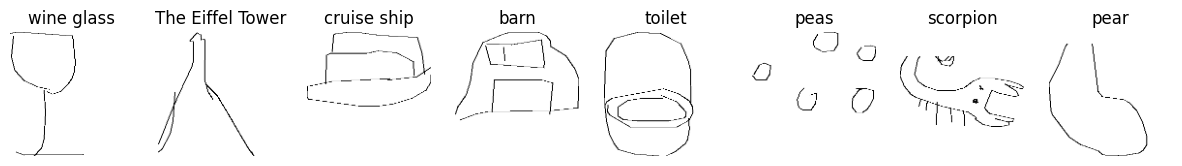

  107/19464 ━━━━━━━━━━━━━━━━━━━━ 5:23:55 1s/step - accuracy: 0.6973 - loss: 1.2548   

In [ ]:
# Resume training from epoch 9 (index 8 in zero-based indexing)
epoch = 8  # Because you completed up to epoch 8, resume from index 8
while epoch < 10:
    print(f"\n{'='*50}")
    print(f"EPOCH {epoch + 1}")
    print(f"{'='*50}")
    
    epoch_paths = partitioned_paths[epoch]
    epoch_labels = partitioned_labels[epoch]

    # Exclude validation images
    train_paths_current = []
    train_labels_current = []
    for path, label in zip(epoch_paths, epoch_labels):
        if path not in val_set:
            train_paths_current.append(path)
            train_labels_current.append(label)

    print(f"Current epoch training samples: {len(train_paths_current)}")
    
    if len(train_paths_current) == 0:
        print("No training samples for this epoch, skipping...")
        epoch += 1
        continue

    train_gen = SketchDataGenerator(train_paths_current, train_labels_current, BATCH_SIZE,
                                    class_to_idx, PARTIAL_STEPS, shuffle=True, vali=False)

    train_gen.get_class_distribution_debug(num_batches=5)
    debug_data_distribution(train_gen, val_gen, class_to_idx)

    # Optional preview
    train_batch_x, train_batch_y = train_gen[0]
    preview_batch_images(train_batch_x, train_batch_y, {v: k for k, v in class_to_idx.items()})

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS_PER_CHUNK,
        callbacks=[checkpoint_callback, validation_monitor, early_stopping, reduce_lr],
        verbose=1
    )

    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Acc: {final_train_acc:.4f}")
    print(f"  Val Acc: {final_val_acc:.4f}")
    print(f"  Val Loss: {history.history['val_loss'][-1]:.4f}")

    if final_train_acc - final_val_acc > 0.3:
        print("[WARNING] Large train-val accuracy gap detected. Consider stopping.")

    if final_val_acc >= target_val_acc:
        print(f"Target validation accuracy {target_val_acc} reached!")
        break

    epoch += 1

print("\n[INFO] Training resumed and completed!")

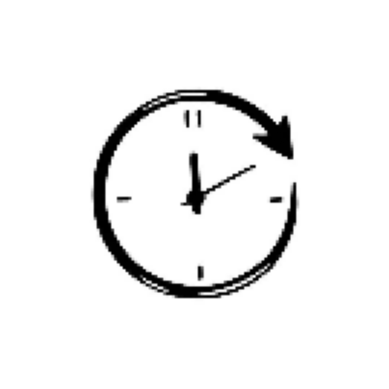

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
Predicted class: eye
Top 10 predictions:
  eye: 0.4358
  goatee: 0.1569
  lion: 0.0193
  panda: 0.0190
  power outlet: 0.0130
  face: 0.0127
  blueberry: 0.0115
  bandage: 0.0113
  blackberry: 0.0107
  washing machine: 0.0101
  hurricane: 0.0095
  smiley face: 0.0090
  soccer ball: 0.0090
  donut: 0.0086
  purse: 0.0079
  garden hose: 0.0075
  raccoon: 0.0071
  onion: 0.0062
  alarm clock: 0.0061
  camouflage: 0.0060


In [13]:
from tensorflow.keras.models import load_model
model = load_model("checkpoints/step_90000.keras")
def predict_image(model, image_path):
    """Predict the class of a single image."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")

    classes = sorted(os.listdir(DATA_DIR))
    class_to_idx = {cls: i for i, cls in enumerate(classes)}
    #preprocess image like training data
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    
    #view the image
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()
    # Make prediction
    prediction = model.predict(img)
    predicted_class_idx = np.argmax(prediction, axis=1)[0]
    #show top 10 predictions
    top_indices = np.argsort(prediction[0])[::-1][:20]
    top_classes = [list(class_to_idx.keys())[i] for i in top_indices]
    top_probs = prediction[0][top_indices]
    print(f"Predicted class: {list(class_to_idx.keys())[predicted_class_idx]}")
    print("Top 10 predictions:")
    for cls, prob in zip(top_classes, top_probs):
        print(f"  {cls}: {prob:.4f}")
    return predicted_class_idx
# Example usage
image_path = "/mnt/d/MyEverything/PythonProjects/Recent_projects/cnn_analysis/Hand_Drawing/clock.jpg"
predicted_class_idx = predict_image(model, image_path)